In [1]:
import autograd.numpy as np
from autograd import grad
import cvxpy as cp
import matplotlib.pyplot as plt

import pymanopt
import pymanopt.manifolds
import pymanopt.solvers
# from pymanopt.solvers import TrustRegions

from numpy.random import default_rng

import networkx as nx

from opt_utils import hyperplane_rounding, normalize_rows, eigen_proj, load_graph

In [2]:
def cost(Y):
    return -1/4 * np.trace(Y @ Y.T @ L)

In [3]:
# one iteration of elliptope optimization
def iterate_elliptope(rank, n, L, initial_Y=None):
    print("Current rank: %s"  %(rank))

    manifold = pymanopt.manifolds.Elliptope(n, rank)
    @pymanopt.function.Autograd(manifold)
    def manifold_cost(Y):
        return -1/4 * np.trace(Y @ Y.T @ L)

    problem = pymanopt.Problem(manifold=manifold, cost=manifold_cost)
    solver = pymanopt.solvers.SteepestDescent(minstepsize=1e-3)
    solution = solver.solve(problem, x=initial_Y)

    return solution, manifold_cost(solution)

In [4]:
# reduce rank by optimizing over a manifold
def closest_point(Y):
    X = Y @ Y.T
    target_rank = np.linalg.matrix_rank(X, tol=1e-6) - 1
    Y_proj = Y
    if target_rank >= 2:
        manifold = pymanopt.manifolds.Elliptope(n, target_rank)
        @pymanopt.function.Autograd(manifold)
        def manifold_cost(Y):
            return np.trace(Y @ Y.T @ X)

        problem = pymanopt.Problem(manifold=manifold, cost=manifold_cost)
        solver = pymanopt.solvers.SteepestDescent(minstepsize=1e-3)
        Y_proj = solver.solve(problem)

    return Y_proj, target_rank

### Data

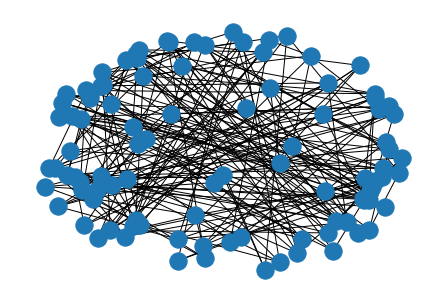

In [5]:
# graph_file = "torusg3-8.dat"
graph_file = "toruspm3-8-50.dat"

n = 100
G = load_graph(graph_file, n)

In [6]:
L = nx.laplacian_matrix(G).toarray() * 1.0
opt_sdp_rank = 34  # the optimal solution from the original BM method paper is 33

## Solve SDP relaxation

In [7]:
sdp_solution, sdp_cost = iterate_elliptope(opt_sdp_rank, n, L)

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +1.7203486129928014e+00    2.71280174e+01    
   2         -2.5359968626468707e+01    2.70580073e+01    
   3         -1.2950069977545525e+02    2.53917336e+01    
   4         -3.5550672565041936e+02    1.52355576e+01    
   5         -4.2216852574421534e+02    1.72761004e+01    
   6         -4.6428386710476718e+02    1.07472182e+01    
   7         -4.8286519378861271e+02    6.00432289e+00    
   8         -4.9172684160263282e+02    5.69094289e+00    
   9         -4.9683903279957002e+02    6.30373166e+00    
  10         -4.9997902214424141e+02    6.84963786e+00    
  11         -5.0638129571001735e+02    2.56318165e+00    
  12         -5.1033751593008685e+02    6.48326651e+00    
  13         -5.1400456194101980e+02    4.17508389e+00    
  14         -5.1537646685224195e+02    3.54076180e+00    
  15         -5.163454699

## Manifold iteration

### Eigenprojection + hyperplane rounding

In [11]:
eigen_proj_ranks = []
eigen_proj_costs = []

rank_new = opt_sdp_rank
Y_new = None
solution_new = None
while (rank_new > 1):
    solution_new, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    eigen_proj_ranks += [rank_new]
    eigen_proj_costs += [-cost_val]
    Y_new, rank_new = eigen_proj(solution_new, True)
eigen_proj_solution, eigen_proj_cost = hyperplane_rounding(solution_new, cost)
eigen_proj_simple_rounding_cost = cost(Y_new)
eigen_proj_ranks += [1, 1]
eigen_proj_costs += [-eigen_proj_cost, -eigen_proj_simple_rounding_cost]

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         -1.5605738607256709e+00    2.72084586e+01    
   2         -2.8715449614254918e+01    2.71268839e+01    
   3         -1.3305202431531862e+02    2.54135322e+01    
   4         -3.5821612178718726e+02    1.52173157e+01    
   5         -4.2288622029699843e+02    1.75093957e+01    
   6         -4.6761500782011171e+02    9.86873698e+00    
   7         -4.8241553819169405e+02    7.92986571e+00    
   8         -4.9128847333810330e+02    7.00678045e+00    
   9         -4.9889876880287727e+02    4.34885585e+00    
  10         -5.0085971214747485e+02    7.52624652e+00    
  11         -5.0663219955325951e+02    3.77627730e+00    
  12         -5.0924039463535416e+02    3.02842790e+00    
  13         -5.1108421332364031e+02    3.63101976e+00    
  14         -5.1185924861484864e+02    4.68853710e+00    
  15         -5.141309143

### Closest point + hyperplane rounding

In [12]:
closest_point_ranks = []
closest_point_costs = []

rank_new = opt_sdp_rank
Y_new = None
solution_new = None
while (rank_new > 1):
    solution_new, cost_val = iterate_elliptope(rank_new, n, L, Y_new)
    closest_point_ranks += [rank_new]
    closest_point_costs += [-cost_val]
    Y_new, rank_new = closest_point(solution_new)
closest_point_solution, closest_point_cost = hyperplane_rounding(solution_new, cost)
closest_point_ranks += [1]
closest_point_costs += [-closest_point_cost]

Current rank: 34
Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +5.9566132402655869e-01    2.73083178e+01    
   2         -2.6664946449704100e+01    2.72379731e+01    
   3         -1.3148612286291564e+02    2.55466164e+01    
   4         -3.5789501518260835e+02    1.52245630e+01    
   5         -4.2324889860928965e+02    1.74406347e+01    
   6         -4.6715608353413978e+02    1.01581539e+01    
   7         -4.8329834131129473e+02    7.27405662e+00    
   8         -4.8885352207837263e+02    9.14688905e+00    
   9         -5.0048017225037444e+02    3.26829748e+00    
  10         -5.0812648092767472e+02    7.43374987e+00    
  11         -5.1483712237827058e+02    2.21457778e+00    
  12         -5.1597335998306312e+02    3.16508185e+00    
  13         -5.1690050933565828e+02    3.10681738e+00    
  14         -5.1804087318435893e+02    2.32670620e+00    
  15         -5.188177344

## Benchmark: hyperplane rounding of SDP solution

In [13]:
_, hyperplane_rounding_cost= hyperplane_rounding(sdp_solution, cost)

## Plots

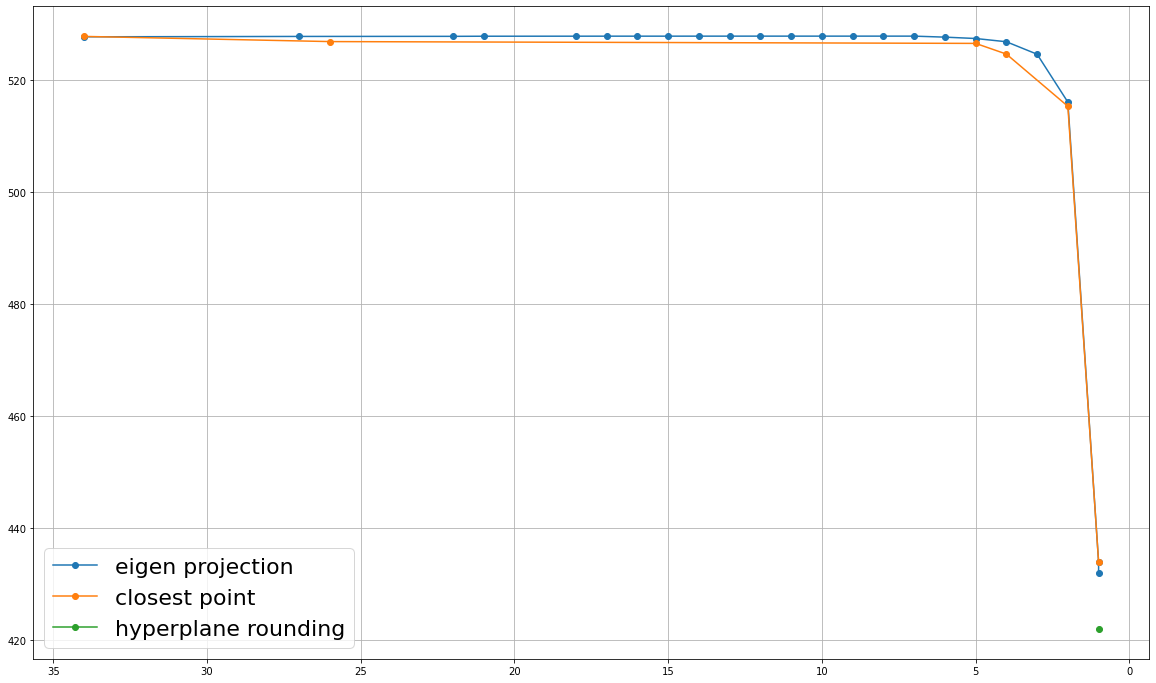

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 12)
ax.invert_xaxis()

plt.plot(eigen_proj_ranks, eigen_proj_costs, label="eigen projection", marker="o")
plt.plot(closest_point_ranks, closest_point_costs, label="closest point", marker="o")

plt.plot([1], [-hyperplane_rounding_cost], label="hyperplane rounding", marker="o")

plt.legend(loc='lower left', fontsize=22)
plt.grid()